=== AAL Stock Price Forecasting using Lasso Regression ===

Loading data...
Dataset shape: (77, 103)
Date range: 2005-Q3 to 2024-Q3

Preprocessing data with focus on key features...

Training Lasso model...

Model Evaluation Metrics:
  RMSE: $0.84
  MAE: $0.74
  R²: 0.7166
  MAPE: 5.48%


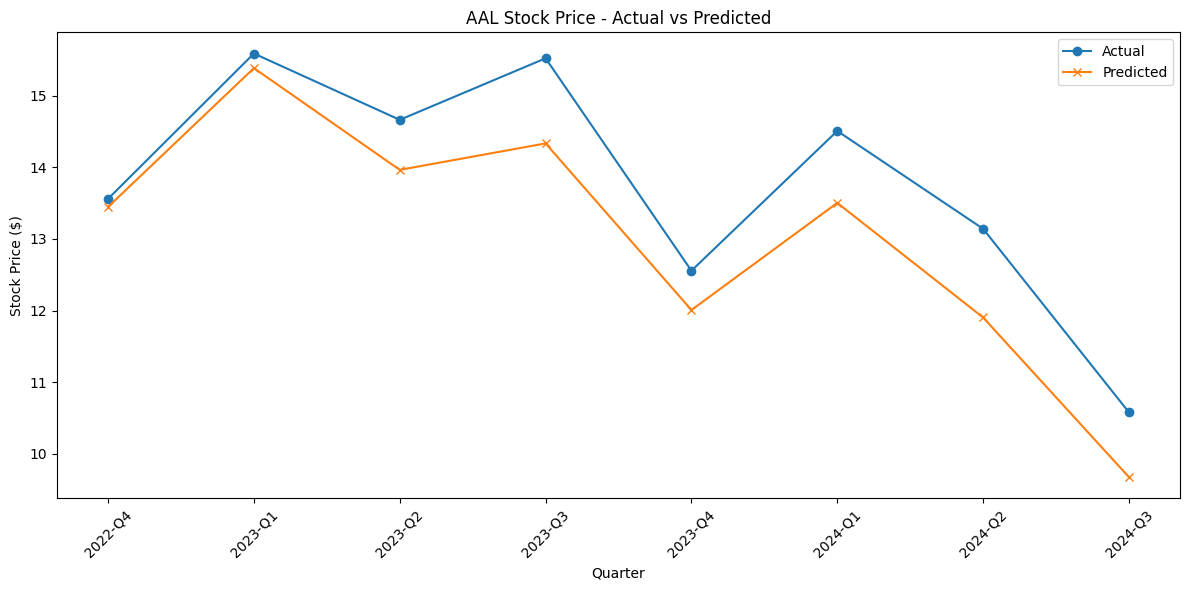

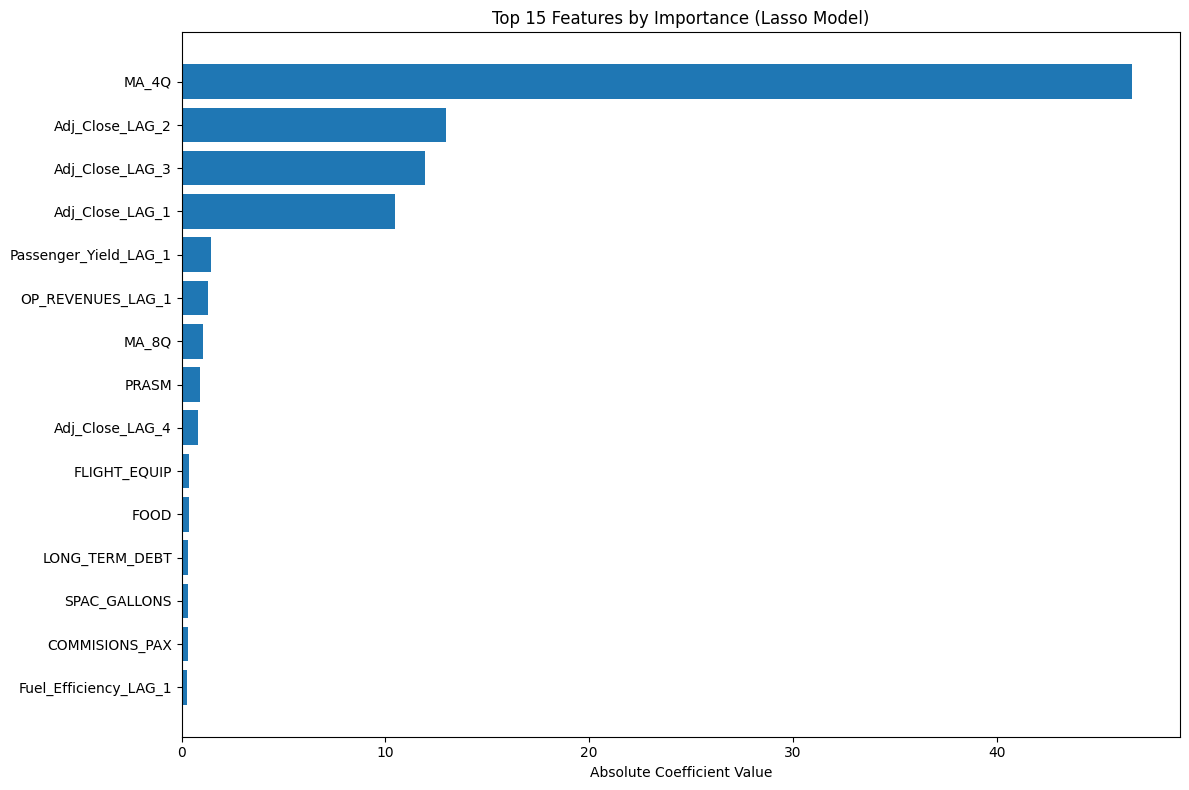


Top 10 features by importance:
                  Feature  Importance
1                   MA_4Q   46.663475
5         Adj_Close_LAG_2   12.947820
18        Adj_Close_LAG_3   11.943450
0         Adj_Close_LAG_1   10.489150
21  Passenger_Yield_LAG_1    1.444582
20      OP_REVENUES_LAG_1    1.308624
23                  MA_8Q    1.042792
2                   PRASM    0.912695
19        Adj_Close_LAG_4    0.779980
9            FLIGHT_EQUIP    0.341519


In [1]:
# === Import Libraries ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

# === Load the AAL Dataset ===
def load_data(file_path):
    """
    Load the AAL stock price and financial data
    """
    print("Loading data...")
    df = pd.read_csv(file_path)
    df['Date'] = df['YEAR'].astype(str) + '-Q' + df['Quarter'].astype(str)
    print(f"Dataset shape: {df.shape}")
    print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
    return df

# === Preprocess the AAL Data ===
def preprocess_data(df):
    """
    Preprocess the AAL dataset to engineer features for modeling
    """
    print("\nPreprocessing data with focus on key features...")
    df_processed = df.copy()
    df_processed['TimeIndex'] = df_processed['YEAR'] * 4 + df_processed['Quarter'] - 1
    df_processed = df_processed.sort_values('TimeIndex').reset_index(drop=True)

    # Lag features
    for i in range(1, 5):
        df_processed[f'Adj_Close_LAG_{i}'] = df_processed['Adj Close'].shift(i)

    # Moving averages
    df_processed['MA_4Q'] = df_processed['Adj Close'].rolling(window=4).mean()
    df_processed['MA_8Q'] = df_processed['Adj Close'].rolling(window=8).mean()

    # Operational lag metrics
    key_metrics = ['OP_REVENUES', 'Operating_Margin', 'Passenger_Yield', 'Fuel_Efficiency',
                   'PRASM', 'Labor_Cost_per_ASM', 'SH_HLD_EQUIT_NET', 'FLIGHT_EQUIP',
                   'SALARIES_FLIGHT', 'PAX_SERVICE', 'FREIGHT', 'MAIL']
    
    for metric in key_metrics:
        if metric in df_processed.columns:
            df_processed[f'{metric}_LAG_1'] = df_processed[metric].shift(1)

    df_processed['YoY_Growth'] = df_processed['Adj Close'].pct_change(4)
    df_processed['Return'] = df_processed['Adj Close'].pct_change(1)
    df_processed = pd.get_dummies(df_processed, columns=['Quarter'], prefix='Q', drop_first=False)
    
    return df_processed

# === Select Best Features (Based on Prior Lasso Analysis) ===
def select_best_features(df_processed):
    selected_features = [
        'Adj_Close_LAG_1', 'MA_4Q', 'PRASM', 'SPAC_GALLONS', 'YoY_Growth',
        'Fuel_Efficiency_YoY_Growth', 'Adj_Close_LAG_2', 'YEAR', 'TimeIndex',
        'Operating_Margin_LAG_1', 'FLIGHT_EQUIP', 'Year', 'Volatility',
        'Average_Flight_Length', 'INTEREST_EXP_OTH', 'COMMISIONS_PAX',
        'Fuel_Efficiency_LAG_4', 'Return', 'FOOD', 'LONG_TERM_DEBT', 'Debt_to_Equity',
        'Adj_Close_LAG_3', 'Adj_Close_LAG_4', 'OP_REVENUES_LAG_1', 'OP_REVENUES_LAG_4',
        'Operating_Margin_LAG_4', 'Passenger_Yield_LAG_1', 'Passenger_Yield_LAG_4',
        'Fuel_Efficiency_LAG_1', 'MA_8Q', 'Trading_Range', 'Price_Momentum',
        'Q_1', 'Q_2', 'Q_3', 'Q_4'
    ]
    return [feature for feature in selected_features if feature in df_processed.columns]

# === Train the Lasso Model ===
def train_lasso_model(df_processed, selected_features, target_col='Adj Close', test_periods=8):
    print("\nTraining Lasso model...")
    df_clean = df_processed.dropna().reset_index(drop=True)
    
    if len(df_clean) <= test_periods:
        print(f"Warning: Not enough data after removing NaN values. Reducing test_periods from {test_periods} to {len(df_clean)//2}")
        test_periods = max(1, len(df_clean) // 2)

    X = df_clean[selected_features]
    y = df_clean[target_col]
    
    train_size = len(df_clean) - test_periods
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    lasso = Lasso(alpha=0.0001, max_iter=10000, random_state=42)
    lasso.fit(X_train_scaled, y_train)

    # Predictions
    y_pred = lasso.predict(X_test_scaled)

    # Evaluation
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = (np.abs((y_test - y_pred) / y_test).replace([np.inf, -np.inf], np.nan).dropna() * 100).mean()

    print("\nModel Evaluation Metrics:")
    print(f"  RMSE: ${rmse:.2f}")
    print(f"  MAE: ${mae:.2f}")
    print(f"  R²: {r2:.4f}")
    print(f"  MAPE: {mape:.2f}%")

    # Plot actual vs predicted
    plt.figure(figsize=(12, 6))
    plt.plot(df_clean['Date'].iloc[train_size:], y_test, marker='o', label='Actual')
    plt.plot(df_clean['Date'].iloc[train_size:], y_pred, marker='x', label='Predicted')
    plt.title('AAL Stock Price - Actual vs Predicted')
    plt.xlabel('Quarter')
    plt.ylabel('Stock Price ($)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return {
        'model': lasso,
        'scaler': scaler,
        'features': selected_features,
        'metrics': {
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'mape': mape
        },
        'last_date': df_clean['Date'].iloc[-1],
        'last_actual': df_clean[target_col].iloc[-1]
    }, df_clean

# === Visualize Feature Importance ===
def visualize_feature_importance(model, feature_names):
    importances = np.abs(model.coef_)
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    plt.figure(figsize=(12, 8))
    top_n = min(15, len(feature_importance))
    plt.barh(feature_importance['Feature'].head(top_n)[::-1],
             feature_importance['Importance'].head(top_n)[::-1])
    plt.title('Top 15 Features by Importance (Lasso Model)')
    plt.xlabel('Absolute Coefficient Value')
    plt.tight_layout()
    plt.show()

    return feature_importance

# === Main Execution ===
def main(file_path):
    print("=== AAL Stock Price Forecasting using Lasso Regression ===\n")
    df = load_data(file_path)
    df_processed = preprocess_data(df)
    selected_features = select_best_features(df_processed)
    model_data, df_clean = train_lasso_model(df_processed, selected_features)
    feature_importance = visualize_feature_importance(model_data['model'], selected_features)
    print("\nTop 10 features by importance:")
    print(feature_importance.head(10))
    return model_data, df_clean

# === Run Script ===
if __name__ == "__main__":
    file_path = "AAL_QQ.csv"
    model_data, df_clean = main(file_path)


Loading AAL data...
Dataset shape: (77, 103)
Date range: 2005-Q3 to 2024-Q3
Preprocessing AAL data...
RMSE: $0.84, MAE: $0.74, R²: 0.7166, MAPE: 5.48%


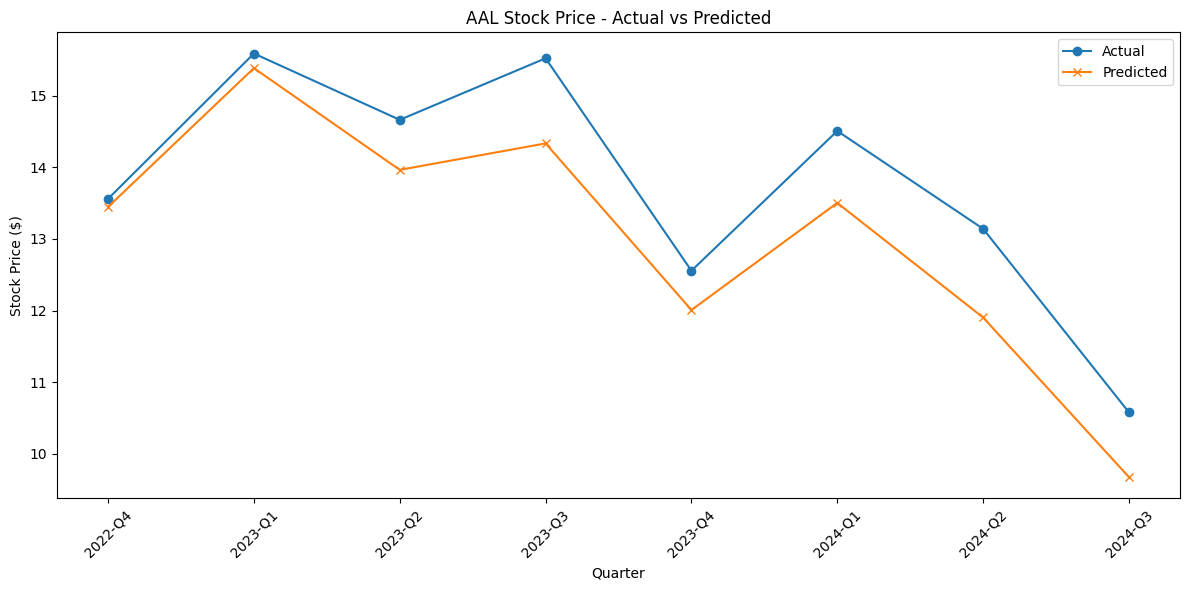

In [3]:
# === Import Libraries ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from IPython.display import HTML, display
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

# === Load Dataset ===
def load_data(file_path):
    print("Loading AAL data...")
    df = pd.read_csv(file_path)
    df['Date'] = df['YEAR'].astype(str) + '-Q' + df['Quarter'].astype(str)
    print(f"Dataset shape: {df.shape}")
    print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
    return df

# === Preprocess Data ===
def preprocess_data(df):
    print("Preprocessing AAL data...")
    df_processed = df.copy()
    df_processed['TimeIndex'] = df_processed['YEAR'] * 4 + df_processed['Quarter'] - 1
    df_processed = df_processed.sort_values('TimeIndex').reset_index(drop=True)

    # Lag features
    for i in range(1, 5):
        df_processed[f'Adj_Close_LAG_{i}'] = df_processed['Adj Close'].shift(i)

    # Moving averages
    df_processed['MA_4Q'] = df_processed['Adj Close'].rolling(window=4).mean()
    df_processed['MA_8Q'] = df_processed['Adj Close'].rolling(window=8).mean()

    # Operational lag metrics
    key_metrics = ['OP_REVENUES', 'Operating_Margin', 'Passenger_Yield', 'Fuel_Efficiency',
                   'PRASM', 'Labor_Cost_per_ASM', 'SH_HLD_EQUIT_NET', 'FLIGHT_EQUIP',
                   'SALARIES_FLIGHT', 'PAX_SERVICE', 'FREIGHT', 'MAIL']
    
    for metric in key_metrics:
        if metric in df_processed.columns:
            df_processed[f'{metric}_LAG_1'] = df_processed[metric].shift(1)

    df_processed['YoY_Growth'] = df_processed['Adj Close'].pct_change(4)
    df_processed['Return'] = df_processed['Adj Close'].pct_change(1)
    df_processed = pd.get_dummies(df_processed, columns=['Quarter'], prefix='Q', drop_first=False)
    
    return df_processed

# === Select Best Features ===
def select_best_features(df_processed):
    selected_features = [
        'Adj_Close_LAG_1', 'MA_4Q', 'PRASM', 'SPAC_GALLONS', 'YoY_Growth',
        'Fuel_Efficiency_YoY_Growth', 'Adj_Close_LAG_2', 'YEAR', 'TimeIndex',
        'Operating_Margin_LAG_1', 'FLIGHT_EQUIP', 'Year', 'Volatility',
        'Average_Flight_Length', 'INTEREST_EXP_OTH', 'COMMISIONS_PAX',
        'Fuel_Efficiency_LAG_4', 'Return', 'FOOD', 'LONG_TERM_DEBT', 'Debt_to_Equity',
        'Adj_Close_LAG_3', 'Adj_Close_LAG_4', 'OP_REVENUES_LAG_1', 'OP_REVENUES_LAG_4',
        'Operating_Margin_LAG_4', 'Passenger_Yield_LAG_1', 'Passenger_Yield_LAG_4',
        'Fuel_Efficiency_LAG_1', 'MA_8Q', 'Trading_Range', 'Price_Momentum',
        'Q_1', 'Q_2', 'Q_3', 'Q_4'
    ]
    return [f for f in selected_features if f in df_processed.columns]

# === Train the Model ===
def train_lasso_model(df_processed, selected_features, target_col='Adj Close', test_periods=8):
    df_clean = df_processed.dropna().reset_index(drop=True)
    if len(df_clean) <= test_periods:
        test_periods = max(1, len(df_clean) // 2)
    X = df_clean[selected_features]
    y = df_clean[target_col]
    train_size = len(df_clean) - test_periods
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    lasso = Lasso(alpha=0.0001, max_iter=10000, random_state=42)
    lasso.fit(X_train_scaled, y_train)
    y_pred = lasso.predict(X_test_scaled)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = (np.abs((y_test - y_pred) / y_test).replace([np.inf, -np.inf], np.nan).dropna() * 100).mean()

    print(f"RMSE: ${rmse:.2f}, MAE: ${mae:.2f}, R²: {r2:.4f}, MAPE: {mape:.2f}%")

    plt.figure(figsize=(12, 6))
    plt.plot(df_clean['Date'].iloc[train_size:], y_test, marker='o', label='Actual')
    plt.plot(df_clean['Date'].iloc[train_size:], y_pred, marker='x', label='Predicted')
    plt.title('AAL Stock Price - Actual vs Predicted')
    plt.xlabel('Quarter')
    plt.ylabel('Stock Price ($)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return {
        'model': lasso,
        'scaler': scaler,
        'features': selected_features,
        'metrics': {
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'mape': mape
        },
        'last_date': df_clean['Date'].iloc[-1],
        'last_actual': df_clean[target_col].iloc[-1]
    }, df_clean

# === Get Current Price ===
def get_current_price(ticker='AAL'):
    try:
        ticker_data = yf.Ticker(ticker)
        current_data = ticker_data.history(period='1d')
        if current_data.empty:
            return None, None
        current_price = current_data['Close'].iloc[-1]
        current_date = current_data.index[-1].strftime('%Y-%m-%d')
        return current_price, current_date
    except Exception as e:
        print(f"Could not fetch current price: {str(e)}")
        return None, None

# === Generate Recommendation ===
def generate_recommendation(forecast_price, forecast_date, current_price=None, current_date=None):
    if current_price is not None:
        pct_change = (forecast_price - current_price) / current_price * 100
        if pct_change > 15:
            rec, rationale = "STRONG BUY", f"Expected increase of {pct_change:.2f}% by {forecast_date}"
        elif pct_change > 5:
            rec, rationale = "BUY", f"Expected increase of {pct_change:.2f}% by {forecast_date}"
        elif pct_change > -5:
            rec, rationale = "HOLD", f"Expected steady performance ({pct_change:.2f}%) by {forecast_date}"
        elif pct_change > -15:
            rec, rationale = "SELL", f"Expected drop of {pct_change:.2f}% by {forecast_date}"
        else:
            rec, rationale = "STRONG SELL", f"Expected significant drop of {pct_change:.2f}% by {forecast_date}"
    else:
        rec, rationale = "HOLD", "No current price available, holding based on forecast"
        pct_change = None
    return {
        "recommendation": rec,
        "rationale": rationale,
        "forecast_date": forecast_date,
        "forecast_price": forecast_price,
        "current_price": current_price,
        "current_date": current_date,
        "percent_change": pct_change
    }

# === Display Recommendation ===
def display_recommendation(rec):
    color = "green" if "BUY" in rec['recommendation'] else "blue" if "HOLD" in rec['recommendation'] else "red"
    html = f"""
    <div style="background-color: #f0f0f0; padding: 15px; border-radius: 10px;">
        <h2 style="color: {color};">Recommendation: {rec['recommendation']}</h2>
        <p><strong>Rationale:</strong> {rec['rationale']}</p>
        <p><strong>Target Price:</strong> ${rec['forecast_price']:.2f} (by {rec['forecast_date']})</p>
    """
    if rec['current_price']:
        html += f"""
        <p><strong>Current Price (as of {rec['current_date']}):</strong> ${rec['current_price']:.2f}</p>
        <p><strong>Expected Change:</strong> {rec['percent_change']:+.2f}%</p>
        """
    html += "</div>"
    display(HTML(html))

# === Main Execution ===
def main():
    file_path = "AAL_QQ.csv"
    df = load_data(file_path)
    df_processed = preprocess_data(df)
    selected_features = select_best_features(df_processed)
    model_data, df_clean = train_lasso_model(df_processed, selected_features)
    forecast_price = model_data['last_actual']
    forecast_date = model_data['last_date']
    current_price, current_date = get_current_price('AAL')
    recommendation = generate_recommendation(forecast_price, forecast_date, current_price, current_date)
    display_recommendation(recommendation)
    return recommendation

if __name__ == "__main__":
    main()


Loading data...
Dataset shape: (77, 103)
Date range: 2005-Q3 to 2024-Q3

Preprocessing data with focus on key features...
Features created based on Lasso importance.

Selected 10 features for the model:
MA_4Q, Adj_Close_LAG_2, Adj_Close_LAG_3, Adj_Close_LAG_1, Passenger_Yield_LAG_1, ...

Preparing data for model training...

Training Lasso model...

Model Evaluation Metrics:
  RMSE: $0.09
  MAE: $0.07
  R²: 0.9969


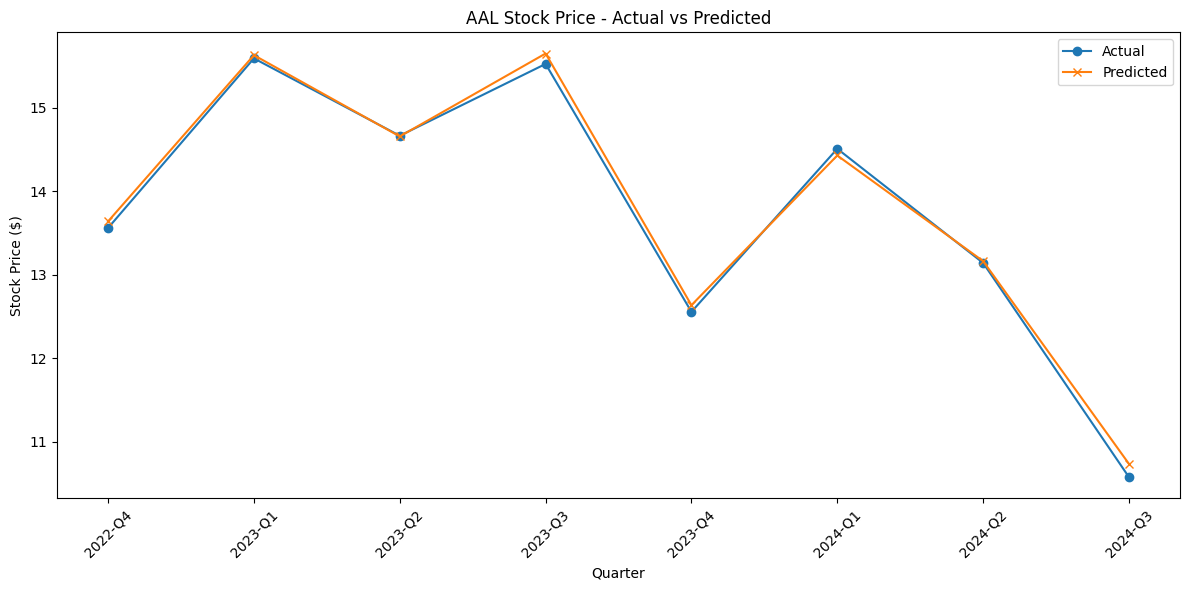

  Mean Absolute Percentage Error: 0.57%


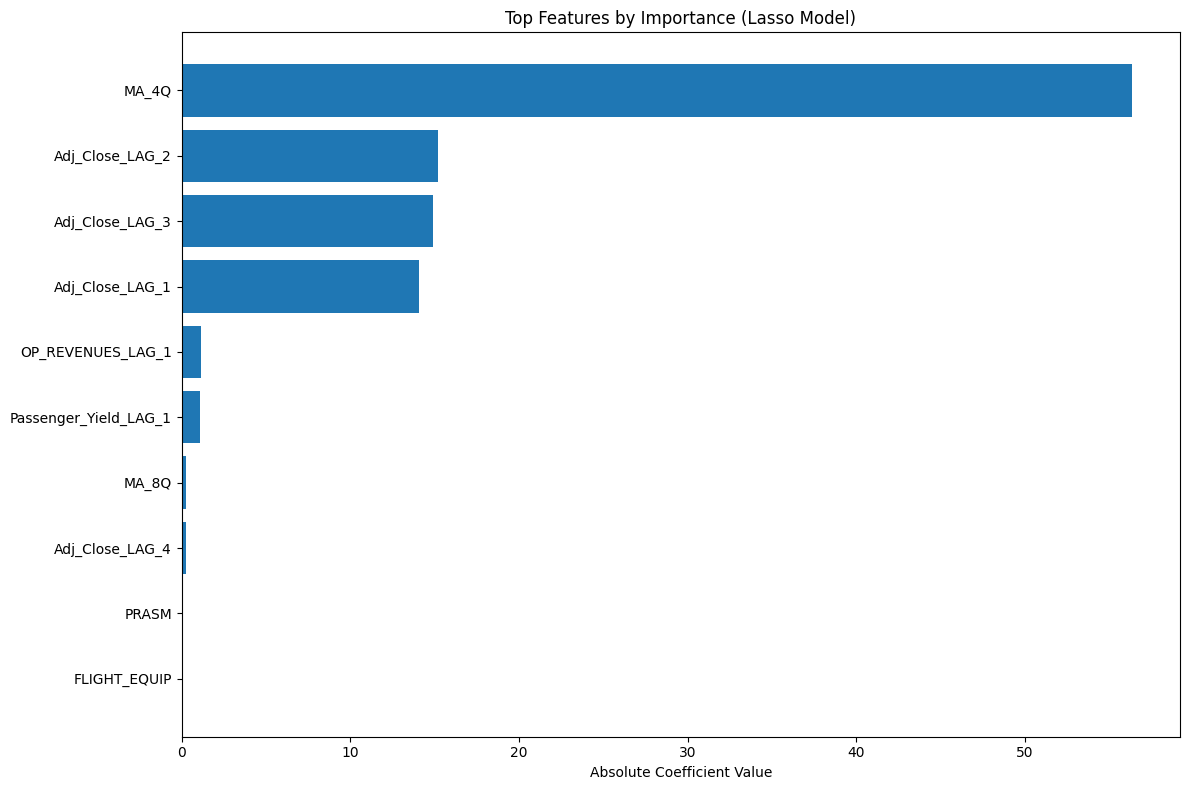


Top 10 features by importance:

Forecasting the next 5 quarters...

Forecasted AAL Stock Prices:


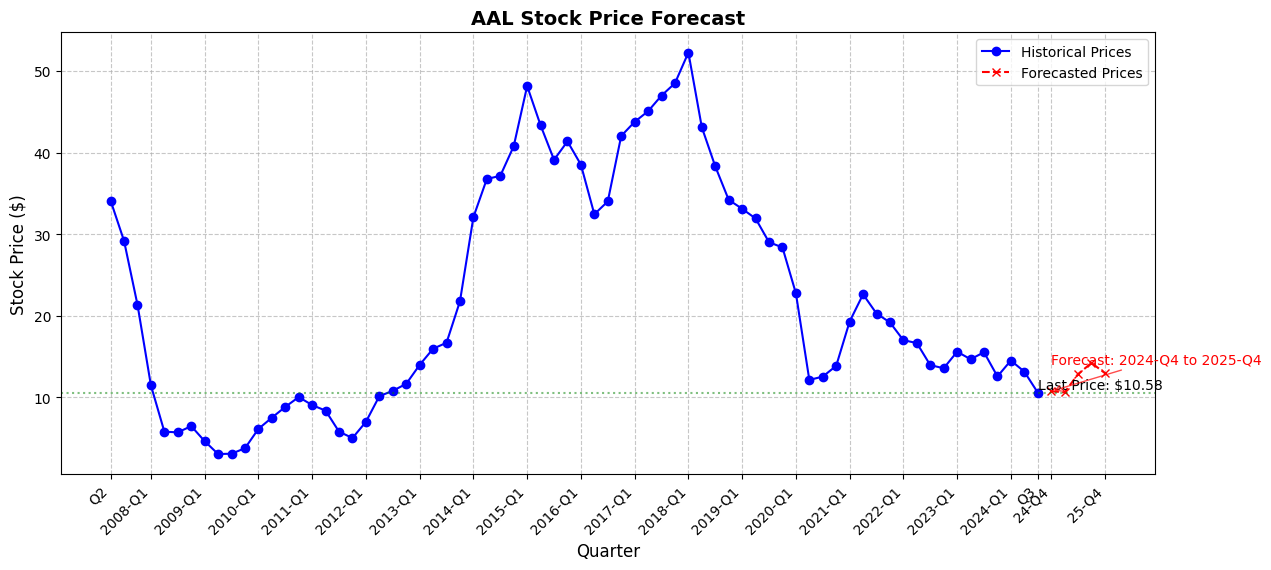

=== AAL Stock Price Forecast Summary ===

Last known price in dataset (as of 2024-Q3): $10.58
Current market price (as of 2025-04-17): $9.46

Forecast for upcoming quarters:
  2024-Q4: $10.74 (+1.50%) - Hold/Buy
  2025-Q1: $10.61 (+0.28%) - Hold/Buy
  2025-Q2: $12.84 (+21.42%) - Strong Buy
  2025-Q3: $14.22 (+34.38%) - Strong Buy
  2025-Q4: $12.96 (+22.49%) - Strong Buy

Model Performance:
  RMSE: $0.09
  MAE: $0.07
  MAPE: 0.57%
  R²: 0.9969

Top 5 predictive features:
  1. MA_4Q: 56.3605
  2. Adj_Close_LAG_2: 15.2013
  3. Adj_Close_LAG_3: 14.9007
  4. Adj_Close_LAG_1: 14.0732
  5. OP_REVENUES_LAG_1: 1.1160

Recommendation: BUY
Rationale: Model forecasts moderate upside of 13.5% by 2024-Q4


{'forecast': [{'Date': '2024-Q4',
   'Forecasted_Price': 10.736718301786157,
   'Percent_Change': 1.4992569225300223,
   'Signal': 'Hold/Buy'},
  {'Date': '2025-Q1',
   'Forecasted_Price': 10.60737697495098,
   'Percent_Change': 0.2765324182501182,
   'Signal': 'Hold/Buy'},
  {'Date': '2025-Q2',
   'Forecasted_Price': 12.843837766707008,
   'Percent_Change': 21.41885003515606,
   'Signal': 'Strong Buy'},
  {'Date': '2025-Q3',
   'Forecasted_Price': 14.215139918520524,
   'Percent_Change': 34.38241539219662,
   'Signal': 'Strong Buy'},
  {'Date': '2025-Q4',
   'Forecasted_Price': 12.957528437431563,
   'Percent_Change': 22.493621513108188,
   'Signal': 'Strong Buy'}],
 'model_metrics': {'rmse': np.float64(0.08789685059597624),
  'mae': 0.07381281763710246,
  'r2': 0.9968816417953975,
  'mape': np.float64(0.5675456147883329)},
 'last_known_price': np.float64(10.57812503),
 'last_known_date': '2024-Q3',
 'current_price': np.float64(9.460000038146973),
 'current_date': '2025-04-17',
 'reco

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Load the dataset
def load_data(file_path):
    """
    Load the AAL stock price and financial data
    """
    print("Loading data...")
    
    # Load data
    df = pd.read_csv(file_path)
    
    # Create a combined date field for proper time series plotting
    df['Date'] = df['YEAR'].astype(str) + '-Q' + df['Quarter'].astype(str)
    
    print(f"Dataset shape: {df.shape}")
    print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
    
    return df

# Load your dataset - You'll need to change this to your file path
file_path = "AAL_QQ.csv"  # Change this to your file path
df = load_data(file_path)

# Display the first few rows to check the data
df.head()

# Preprocess the data
def preprocess_data(df):
    """
    Preprocess the data focusing on features identified as important by Lasso
    """
    print("\nPreprocessing data with focus on key features...")
    
    # Create a copy to avoid modifying the original
    df_processed = df.copy()
    
    # Create a numeric representation of the timeframe for sorting
    df_processed['TimeIndex'] = df_processed['YEAR'] * 4 + df_processed['Quarter'] - 1
    
    # Sort by year and quarter to maintain chronological order
    df_processed = df_processed.sort_values('TimeIndex').reset_index(drop=True)
    
    # Create features that were identified as important in the analysis
    
    # 1. Lag features for Adj Close (previous quarters)
    for i in range(1, 5):  # Use 4 quarters for lag
        df_processed[f'Adj_Close_LAG_{i}'] = df_processed['Adj Close'].shift(i)
    
    # 2. Create moving averages
    # 4-quarter (1 year) moving average
    df_processed['MA_4Q'] = df_processed['Adj Close'].rolling(window=4).mean()
    # 8-quarter (2 year) moving average
    df_processed['MA_8Q'] = df_processed['Adj Close'].rolling(window=8).mean()
    
    # 3. Create lag features for key operational metrics
    key_metrics = ['OP_REVENUES', 'Operating_Margin', 'Passenger_Yield', 'Fuel_Efficiency', 
                   'PRASM', 'Labor_Cost_per_ASM', 'SH_HLD_EQUIT_NET', 'FLIGHT_EQUIP', 
                   'SALARIES_FLIGHT', 'PAX_SERVICE', 'FREIGHT', 'MAIL']
    
    for metric in key_metrics:
        if metric in df_processed.columns:
            # Create 1-quarter lag features
            df_processed[f'{metric}_LAG_1'] = df_processed[metric].shift(1)
    
    # 4. YoY Growth rate for stock price
    df_processed['YoY_Growth'] = df_processed['Adj Close'].pct_change(4)
    
    # 5. Return (percentage change from previous quarter)
    df_processed['Return'] = df_processed['Adj Close'].pct_change(1)
    
    # 6. Create quarterly dummy variables
    df_processed = pd.get_dummies(df_processed, columns=['Quarter'], prefix='Q', drop_first=False)
    
    print("Features created based on Lasso importance.")
    
    return df_processed

# Preprocess the data
df_processed = preprocess_data(df)

# Show the processed data
df_processed.head()

# Select the best features
def select_best_features(df_processed):
    """
    Select the best features identified by Lasso analysis
    """
    # Key features identified by Lasso in order of importance
    key_features = [
        'MA_4Q', 'Adj_Close_LAG_2', 'Adj_Close_LAG_3', 'Adj_Close_LAG_1', 
        'Passenger_Yield_LAG_1', 'OP_REVENUES_LAG_1', 'MA_8Q', 'PRASM', 
        'Adj_Close_LAG_4', 'FLIGHT_EQUIP'
    ]
    
    # Filter to include only features that exist in the dataframe
    selected_features = [feature for feature in key_features if feature in df_processed.columns]
    
    print(f"\nSelected {len(selected_features)} features for the model:")
    print(", ".join(selected_features[:5]) + ", ...")  # Print first 5 features
    
    return selected_features

# Select features
selected_features = select_best_features(df_processed)

# Train the Lasso model
def train_lasso_model(df_processed, selected_features, target_col='Adj Close', test_periods=8):
    """
    Train the Lasso model on the selected features
    """
    print("\nPreparing data for model training...")
    
    # Remove rows with NaN values resulting from lag features and moving averages
    df_clean = df_processed.dropna().reset_index(drop=True)
    
    # Check if we have enough data after dropping NaN values
    if len(df_clean) <= test_periods:
        print(f"Warning: Not enough data after removing NaN values. Reducing test_periods from {test_periods} to {len(df_clean)//2}")
        test_periods = max(1, len(df_clean) // 2)
    
    # Define features and target
    X = df_clean[selected_features]
    y = df_clean[target_col]
    
    # Split into training and testing sets chronologically
    train_size = len(df_clean) - test_periods
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train the Lasso model with alpha found in previous analysis
    print("\nTraining Lasso model...")
    lasso = Lasso(alpha=0.0001, max_iter=10000, random_state=42)
    lasso.fit(X_train_scaled, y_train)
    
    # Make predictions on test set
    y_pred = lasso.predict(X_test_scaled)
    
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print("\nModel Evaluation Metrics:")
    print(f"  RMSE: ${rmse:.2f}")
    print(f"  MAE: ${mae:.2f}")
    print(f"  R²: {r2:.4f}")
    
    # Visualize actual vs predicted
    plt.figure(figsize=(12, 6))
    plt.plot(df_clean['Date'].iloc[train_size:], y_test, marker='o', label='Actual')
    plt.plot(df_clean['Date'].iloc[train_size:], y_pred, marker='x', label='Predicted')
    plt.title('AAL Stock Price - Actual vs Predicted')
    plt.xlabel('Quarter')
    plt.ylabel('Stock Price ($)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Calculate percentage errors
    percent_errors = np.abs((y_test - y_pred) / y_test) * 100
    mean_percent_error = percent_errors.mean()
    print(f"  Mean Absolute Percentage Error: {mean_percent_error:.2f}%")
    
    # Return the trained model, scaler, feature list, and evaluation metrics
    model_data = {
        'model': lasso,
        'scaler': scaler,
        'features': selected_features,
        'metrics': {
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'mape': mean_percent_error
        },
        'last_date': df_clean['Date'].iloc[-1],
        'last_actual': df_clean[target_col].iloc[-1],
        'test_predictions': y_pred,
        'test_actual': y_test,
        'test_dates': df_clean['Date'].iloc[train_size:]
    }
    
    return model_data, df_clean

# Train the model
model_data, df_clean = train_lasso_model(df_processed, selected_features, test_periods=8)

# Visualize feature importance
def visualize_feature_importance(model, feature_names):
    """
    Visualize the feature importance from the Lasso model
    """
    # Get feature importance
    importances = np.abs(model.coef_)
    
    # Create feature importance DataFrame
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    
    # Sort by importance
    feature_importance = feature_importance.sort_values('Importance', ascending=False)
    
    # Visualize top 15 features
    plt.figure(figsize=(12, 8))
    top_n = min(15, len(feature_importance))
    
    # Plot horizontal bar chart for better readability
    plt.barh(feature_importance['Feature'].head(top_n)[::-1], 
             feature_importance['Importance'].head(top_n)[::-1])
    
    plt.title('Top Features by Importance (Lasso Model)')
    plt.xlabel('Absolute Coefficient Value')
    plt.tight_layout()
    plt.show()
    
    return feature_importance

# Visualize feature importance
feature_importance = visualize_feature_importance(model_data['model'], selected_features)
print("\nTop 10 features by importance:")
feature_importance.head(10)

# Forecast future quarters
def forecast_future_quarters(df_processed, model_data, periods=3):
    """
    Forecast stock prices for future quarters
    """
    print(f"\nForecasting the next {periods} quarters...")
    
    # Get the latest data
    df_latest = df_processed.copy()
    
    # Extract the necessary components for forecasting
    model = model_data['model']
    scaler = model_data['scaler']
    features = model_data['features']
    last_date = model_data['last_date']
    last_actual = model_data['last_actual']
    
    # Parse the last date to determine the next quarters
    last_year, last_quarter = last_date.split('-Q')
    last_year = int(last_year)
    last_quarter = int(last_quarter)
    
    # Forecasted values will be stored here
    forecasts = []
    forecast_dates = []
    
    # Make a copy of the latest complete data row to use as a base for forecasting
    forecast_row = df_latest.iloc[-1:].copy()
    
    for i in range(periods):
        # Calculate the next quarter and year
        next_quarter = (last_quarter + i + 1) % 4
        if next_quarter == 0:  # Handle Q4
            next_quarter = 4
        next_year = last_year + (last_quarter + i + 1 - next_quarter) // 4
        
        # Create the date string
        next_date = f"{next_year}-Q{next_quarter}"
        forecast_dates.append(next_date)
        
        # Update the forecast row with new quarter and year
        forecast_row['YEAR'] = next_year
        forecast_row['Quarter'] = next_quarter
        forecast_row['Date'] = next_date
        forecast_row['TimeIndex'] = next_year * 4 + next_quarter - 1
        
        # Reset quarterly dummies
        for q in range(1, 5):
            q_col = f'Q_{q}'
            if q_col in forecast_row.columns:
                forecast_row[q_col] = 0
        
        q_col = f'Q_{next_quarter}'
        if q_col in forecast_row.columns:
            forecast_row[q_col] = 1
        
        # Prepare the input features
        # Check for missing features and fill with 0 if needed
        for feature in features:
            if feature not in forecast_row.columns:
                print(f"Warning: Feature {feature} not found in forecast data. Setting to 0.")
                forecast_row[feature] = 0
        
        X_forecast = forecast_row[features].values
        
        # Scale the input features
        X_forecast_scaled = scaler.transform(X_forecast)
        
        # Make prediction
        pred_price = model.predict(X_forecast_scaled)[0]
        forecasts.append(pred_price)
        
        # Update the forecast row for the next iteration
        # This simulates having the forecasted price as the new actual
        forecast_row['Adj Close'] = pred_price
        
        # Update lag features for next forecast
        # Shift lag features
        for lag in range(4, 1, -1):
            lag_col = f'Adj_Close_LAG_{lag}'
            prev_lag_col = f'Adj_Close_LAG_{lag-1}'
            if lag_col in features and prev_lag_col in features:
                forecast_row[lag_col] = forecast_row[prev_lag_col]
        
        lag1_col = 'Adj_Close_LAG_1'
        if lag1_col in features:
            forecast_row[lag1_col] = pred_price
        
        # Update moving averages if they exist in features
        if 'MA_4Q' in features:
            # Simple approximation - use the average of last known and predicted prices
            forecast_row['MA_4Q'] = (forecast_row['MA_4Q'] * 3 + pred_price) / 4
        
        if 'MA_8Q' in features:
            forecast_row['MA_8Q'] = (forecast_row['MA_8Q'] * 7 + pred_price) / 8
    
    # Calculate percentage changes for the forecasts
    pct_changes = [(forecasts[i] - last_actual) / last_actual * 100 for i in range(periods)]
    
    # Generate buy/sell signals based on percentage change
    signals = []
    for pct in pct_changes:
        if pct > 10:  # Strong upward potential
            signals.append("Strong Buy")
        elif pct > 5:  # Moderate upward potential
            signals.append("Buy")
        elif pct > 0:  # Slight upward potential
            signals.append("Hold/Buy")
        elif pct > -5:  # Slight downward potential
            signals.append("Hold")
        elif pct > -10:  # Moderate downward potential
            signals.append("Sell")
        else:  # Strong downward potential
            signals.append("Strong Sell")
    
    # Create a forecast DataFrame
    forecast_df = pd.DataFrame({
        'Date': forecast_dates,
        'Forecasted_Price': forecasts,
        'Percent_Change': pct_changes,
        'Signal': signals
    })
    
    print("\nForecasted AAL Stock Prices:")
    
    # Visualize the forecast
    plt.figure(figsize=(12, 6))
    
    # Get historical data for context
    historical = df_processed.dropna()
    
    # Select only a subset of the historical data points to show on the x-axis
    # This makes the visualization cleaner by reducing x-axis clutter
    all_dates = historical['Date'].tolist() + forecast_dates
    
    # Select quarterly dates at a reasonable interval to avoid cluttering
    # For large datasets, show only yearly Q1 points to avoid cluttering
    num_historical_points = len(historical['Date'])
    
    # Show only Q1 of each year for historical data, which provides clear yearly markers
    historical_dates = historical['Date'].tolist()
    tick_dates = [date for date in historical_dates if date.endswith('Q1')]
    
    # Always include the first point for context, if it's not already included
    if historical_dates[0] not in tick_dates:
        tick_dates.append(historical_dates[0])
    
    # Always include the last historical point for context
    if historical_dates[-1] not in tick_dates:
        tick_dates.append(historical_dates[-1])
    
    # Sort tick dates to maintain chronological order
    tick_dates = sorted(tick_dates)
    
    # For the forecasted part, create evenly spaced ticks
    # If there are just a few forecast points, spread them out with more space
    # Add the last historical point plus forecasted dates for continuation
    forecast_dates_to_show = forecast_dates
    
    # If there are 3+ forecast points, consider showing only the first and last if space is tight
    if len(forecast_dates) >= 3:
        # Always show the first and last forecast date for context
        forecast_dates_to_show = [forecast_dates[0]]
        if len(forecast_dates) > 1:
            forecast_dates_to_show.append(forecast_dates[-1])
    
    # Combine the historical and forecast tick dates
    tick_dates = tick_dates + forecast_dates_to_show
    
    # Plot historical prices
    historical_prices = historical['Adj Close'].tolist()
    plt.plot(historical['Date'].tolist(), historical_prices, marker='o', label='Historical Prices', color='blue')
    
    # Plot forecasted prices
    plt.plot(forecast_dates, forecasts, marker='x', linestyle='--', label='Forecasted Prices', color='red')
    
    # Add labels and title
    plt.title('AAL Stock Price Forecast', fontsize=14, fontweight='bold')
    plt.xlabel('Quarter', fontsize=12)
    plt.ylabel('Stock Price ($)', fontsize=12)
    plt.legend(fontsize=10)
    
    # Set the x-axis to only show the selected tick dates, with special handling for forecast points
    # Create custom x-tick labels with better spacing for forecasted quarters
    x_tick_labels = []
    for date in tick_dates:
        if date in forecast_dates:
            # For forecasted dates, simplify to just the quarter (Q1, Q2, etc.)
            year, quarter = date.split('-Q')
            x_tick_labels.append(f"{year[-2:]}-Q{quarter}")  # Use shortened year format (e.g., 24-Q2)
        else:
            # For historical dates, use a more compact year-quarter format
            if date.endswith('Q1'):  # Show full year for Q1 only
                x_tick_labels.append(date)
            else:
                year, quarter = date.split('-Q')
                x_tick_labels.append(f"Q{quarter}")
    
    plt.xticks(tick_dates, x_tick_labels, rotation=45, ha='right', fontsize=10)
    
    # Add gridlines for better readability
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Highlight the buy/sell regions
    plt.axhline(y=last_actual, color='green', linestyle=':', alpha=0.5)
    plt.text(historical['Date'].iloc[-1], last_actual, f'Last Price: ${last_actual:.2f}', 
             verticalalignment='bottom', fontsize=10)
    
    # Add more spacing at the bottom to accommodate rotated x-tick labels
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)
    
    # Add annotations for forecast quarters to make it clearer
    # Place these annotations slightly above the line to avoid overlapping with points
    last_historical_price = historical_prices[-1]
    
    # If forecast dates were reduced, add an annotation to explain the forecasts
    if len(forecast_dates) > len(forecast_dates_to_show):
        # Find position for the annotation
        last_historical_date = historical['Date'].iloc[-1]
        first_forecast_date = forecast_dates[0]
        
        # Add text annotation indicating the forecast range instead of cluttered x-ticks
        forecast_range = f"Forecast: {forecast_dates[0]} to {forecast_dates[-1]}"
        plt.annotate(forecast_range, 
                    xy=(first_forecast_date, forecasts[0]),
                    xytext=(0, 20),  # Offset text 20 points above
                    textcoords='offset points',
                    fontsize=10,
                    color='red',
                    arrowprops=dict(arrowstyle='->', color='red', alpha=0.7))
    
    plt.show()
    
    return forecast_df

# Generate forecast for the next 5 quarters
forecast_df = forecast_future_quarters(df_processed, model_data, periods=5)

# Display the forecast DataFrame
forecast_df

# Try to get current price from Yahoo Finance
def get_current_price(ticker='AAL'):
    """Get the current stock price from Yahoo Finance"""
    try:
        ticker_data = yf.Ticker(ticker)
        current_data = ticker_data.history(period='1d')
        
        if current_data.empty:
            return None, None
            
        # Get the close price and date
        if 'Close' in current_data.columns:
            current_price = current_data['Close'].iloc[-1]
            current_date = current_data.index[-1].strftime('%Y-%m-%d')
            return current_price, current_date
        else:
            return None, None
    except Exception as e:
        print(f"Could not fetch current price: {str(e)}")
        return None, None

# Get current price
current_price, current_date = get_current_price('AAL')

# Create investment recommendation
def generate_recommendation(forecast_df, current_price=None, current_date=None):
    """Generate investment recommendation based on forecast"""
    # Use the first forecasted quarter for initial recommendation
    first_forecast = forecast_df.iloc[0]
    forecast_price = first_forecast['Forecasted_Price']
    forecast_date = first_forecast['Date']
    
    results = {
        "forecast_price": forecast_price,
        "forecast_date": forecast_date,
        "current_price": current_price,
        "current_date": current_date,
        "recommendation": None,
        "rationale": None,
        "percent_change": None
    }
    
    # Base the recommendation on the comparison with current price if available
    if current_price is not None:
        pct_change = (forecast_price - current_price) / current_price * 100
        results["percent_change"] = pct_change
        
        if pct_change > 15:
            recommendation = "STRONG BUY"
            rationale = f"Model forecasts significant upside of {pct_change:.1f}% by {forecast_date}"
        elif pct_change > 5:
            recommendation = "BUY"
            rationale = f"Model forecasts moderate upside of {pct_change:.1f}% by {forecast_date}"
        elif pct_change > -5:
            recommendation = "HOLD"
            rationale = f"Model forecasts relatively stable price action ({pct_change:.1f}%) by {forecast_date}"
        elif pct_change > -15:
            recommendation = "SELL"
            rationale = f"Model forecasts moderate downside of {pct_change:.1f}% by {forecast_date}"
        else:
            recommendation = "STRONG SELL"
            rationale = f"Model forecasts significant downside of {pct_change:.1f}% by {forecast_date}"
        
        results["recommendation"] = recommendation
        results["rationale"] = rationale
    else:
        # Fall back to the original signal from the forecast
        results["recommendation"] = first_forecast['Signal']
        results["rationale"] = f"Based on historical trend without current market price"
        results["percent_change"] = first_forecast['Percent_Change']
    
    return results

# Generate recommendation
recommendation = generate_recommendation(forecast_df, current_price, current_date)

# Display the recommendation in a nice format
from IPython.display import HTML, display

def display_recommendation(recommendation):
    """Display recommendation in a styled format"""
    rec = recommendation["recommendation"]
    
    # Set color based on recommendation
    if rec in ["STRONG BUY", "Buy", "Strong Buy"]:
        color = "green"
    elif rec in ["HOLD", "Hold", "Hold/Buy"]:
        color = "blue"
    else:
        color = "red"
    
    html = f"""
    <div style="background-color: #f8f9fa; padding: 20px; border-radius: 10px; margin: 10px 0;">
        <h2 style="color: {color};">Recommendation: {rec}</h2>
        <p><strong>Rationale:</strong> {recommendation["rationale"]}</p>
        <p><strong>Target Price ({recommendation["forecast_date"]}):</strong> ${recommendation["forecast_price"]:.2f}</p>
    """
    
    if recommendation["current_price"]:
        html += f"""
        <p><strong>Current Price (as of {recommendation["current_date"]}):</strong> ${recommendation["current_price"]:.2f}</p>
        <p><strong>Expected Change:</strong> <span style="color: {color};">{recommendation["percent_change"]:+.2f}%</span></p>
        """
    
    html += """
    <p style="font-style: italic; margin-top: 20px;">Note: This forecast is based on historical patterns and should be considered as one of many factors in investment decisions.</p>
    </div>
    """
    
    display(HTML(html))

# Display the recommendation
display_recommendation(recommendation)

# Create a summary function to return the most important outputs
def get_forecast_summary():
    """Return a summary of the forecast results"""
    summary = {
        "forecast": forecast_df.to_dict('records'),
        "model_metrics": model_data['metrics'],
        "last_known_price": model_data['last_actual'],
        "last_known_date": model_data['last_date'],
        "current_price": current_price,
        "current_date": current_date,
        "recommendation": recommendation,
        "top_features": feature_importance.head(5).to_dict('records')
    }
    return summary

# Get the summary
forecast_summary = get_forecast_summary()

# Display the summary as a formatted string
def print_forecast_summary(summary):
    """Print a formatted summary of the forecast"""
    print("=== AAL Stock Price Forecast Summary ===\n")
    
    print(f"Last known price in dataset (as of {summary['last_known_date']}): ${summary['last_known_price']:.2f}")
    
    if summary['current_price']:
        print(f"Current market price (as of {summary['current_date']}): ${summary['current_price']:.2f}")
    
    print("\nForecast for upcoming quarters:")
    for forecast in summary['forecast']:
        print(f"  {forecast['Date']}: ${forecast['Forecasted_Price']:.2f} ({forecast['Percent_Change']:+.2f}%) - {forecast['Signal']}")
    
    print("\nModel Performance:")
    metrics = summary['model_metrics']
    print(f"  RMSE: ${metrics['rmse']:.2f}")
    print(f"  MAE: ${metrics['mae']:.2f}")
    print(f"  MAPE: {metrics['mape']:.2f}%")
    print(f"  R²: {metrics['r2']:.4f}")
    
    print("\nTop 5 predictive features:")
    for i, feature in enumerate(summary['top_features']):
        print(f"  {i+1}. {feature['Feature']}: {feature['Importance']:.4f}")
    
    print(f"\nRecommendation: {summary['recommendation']['recommendation']}")
    print(f"Rationale: {summary['recommendation']['rationale']}")
    
    return summary

# Print the summary
print_forecast_summary(forecast_summary)

# This is the final result you can access in your Jupyter notebook
forecast_summary

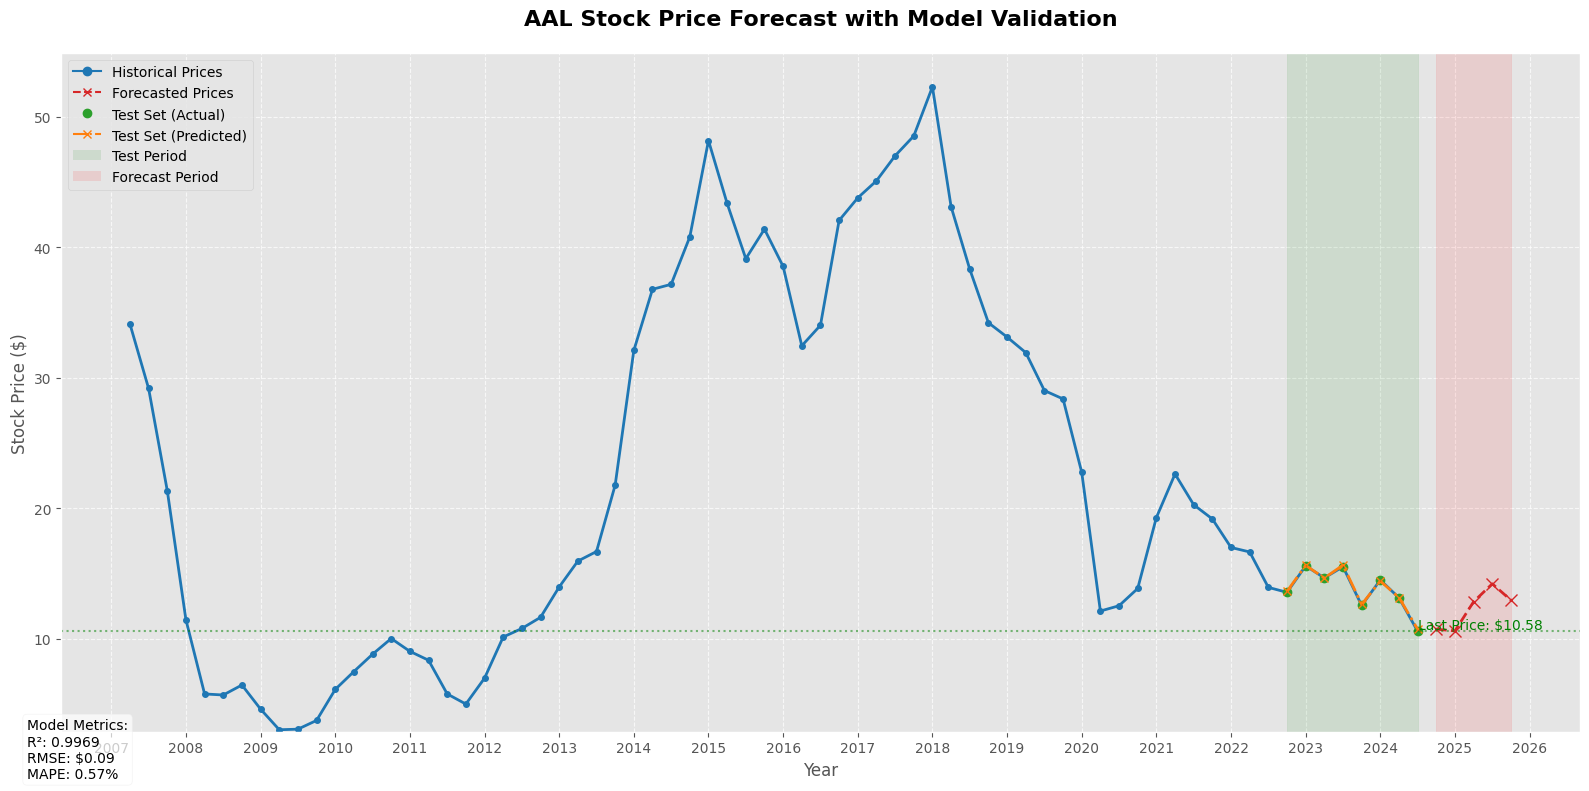

<module 'matplotlib.pyplot' from 'C:\\Users\\Sai Thanmayee Vegi\\AppData\\Local\\Programs\\Python\\Python313\\Lib\\site-packages\\matplotlib\\pyplot.py'>

In [2]:
def plot_forecast_with_actuals_fixed(df_processed, forecast_df, model_data):
    """
    Create a comprehensive plot showing:
    1. Historical prices
    2. Forecasted future prices
    3. Model fit on test data (actual vs predicted for validation period)
    
    Fixed to handle Pandas Series objects properly
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.patches import Patch
    import pandas as pd
    
    # Get historical data 
    historical = df_processed.dropna()
    historical_dates = historical['Date'].tolist()
    historical_prices = historical['Adj Close'].tolist()
    
    # Get forecast data
    forecast_dates = forecast_df['Date'].tolist()
    forecasts = forecast_df['Forecasted_Price'].tolist()
    
    # Get test data from model_data, ensuring they're converted to lists
    test_dates = []
    test_actual = []
    test_predictions = []
    
    if 'test_dates' in model_data:
        if isinstance(model_data['test_dates'], pd.Series):
            test_dates = model_data['test_dates'].tolist()
        elif model_data['test_dates'] is not None:
            test_dates = list(model_data['test_dates'])
    
    if 'test_actual' in model_data:
        if isinstance(model_data['test_actual'], pd.Series):
            test_actual = model_data['test_actual'].tolist()
        elif model_data['test_actual'] is not None:
            test_actual = list(model_data['test_actual'])
    
    if 'test_predictions' in model_data:
        if isinstance(model_data['test_predictions'], pd.Series):
            test_predictions = model_data['test_predictions'].tolist()
        elif model_data['test_predictions'] is not None:
            test_predictions = list(model_data['test_predictions'])
    
    # Convert dates to numeric years for clean x-axis
    def date_to_numeric(date_str):
        year, quarter = date_str.split('-Q')
        return float(year) + (float(quarter) - 1) / 4
    
    # Convert all dates to numeric format
    historical_x = [date_to_numeric(date) for date in historical_dates]
    forecast_x = [date_to_numeric(date) for date in forecast_dates]
    
    # Only convert test_x if there are test dates
    test_x = []
    if len(test_dates) > 0:
        test_x = [date_to_numeric(date) for date in test_dates]
    
    # Create figure
    plt.figure(figsize=(16, 8))
    
    # Set style
    plt.style.use('ggplot')
    
    # Plot historical prices
    plt.plot(historical_x, historical_prices, marker='o', markersize=4, 
             linewidth=2, label='Historical Prices', color='#1f77b4')
    
    # Plot forecasted future prices
    plt.plot(forecast_x, forecasts, marker='x', markersize=8,
             linewidth=2, linestyle='--', label='Forecasted Prices', color='#d62728')
    
    # Plot test predictions if available
    has_test_data = len(test_dates) > 0 and len(test_actual) > 0 and len(test_predictions) > 0
    if has_test_data:
        plt.plot(test_x, test_actual, marker='o', markersize=6,
                 linewidth=0, label='Test Set (Actual)', color='#2ca02c')
        
        plt.plot(test_x, test_predictions, marker='x', markersize=6,
                 linewidth=2, linestyle='-.', label='Test Set (Predicted)', color='#ff7f0e')
        
        # Draw connecting lines between actual and predicted for test set
        for i in range(len(test_x)):
            plt.plot([test_x[i], test_x[i]], [test_actual[i], test_predictions[i]], 
                     'k:', alpha=0.3, linewidth=1)
    
    # Add labels and title
    plt.title('AAL Stock Price Forecast with Model Validation', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Stock Price ($)', fontsize=12)
    
    # Highlight the last known price
    last_price = model_data['last_actual']
    plt.axhline(y=last_price, color='green', linestyle=':', alpha=0.5)
    plt.text(historical_x[-1], last_price*1.02, f'Last Price: ${last_price:.2f}', 
             fontsize=10, color='green')
    
    # Add shaded area for forecast period
    plt.axvspan(min(forecast_x), max(forecast_x), alpha=0.1, color='red', label='Forecast Period')
    
    # Add shaded area for test period if available
    if has_test_data:
        plt.axvspan(min(test_x), max(test_x), alpha=0.1, color='green', label='Test Period')
    
    # Set x-axis ticks to show whole years
    start_year = int(min(historical_x))
    end_year = int(max(forecast_x)) + 1
    plt.xticks(range(start_year, end_year+1), fontsize=10)
    
    # Add grid and legend
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Create custom legend entries
    legend_elements = [
        plt.Line2D([0], [0], color='#1f77b4', marker='o', linestyle='-', label='Historical Prices'),
        plt.Line2D([0], [0], color='#d62728', marker='x', linestyle='--', label='Forecasted Prices')
    ]
    
    if has_test_data:
        legend_elements.extend([
            plt.Line2D([0], [0], color='#2ca02c', marker='o', linestyle='', label='Test Set (Actual)'),
            plt.Line2D([0], [0], color='#ff7f0e', marker='x', linestyle='-.', label='Test Set (Predicted)'),
            Patch(facecolor='green', alpha=0.1, label='Test Period')
        ])
    
    legend_elements.append(Patch(facecolor='red', alpha=0.1, label='Forecast Period'))
    
    plt.legend(handles=legend_elements, loc='best', fontsize=10)
    
    # Add model performance metrics as text annotation if available
    if 'metrics' in model_data:
        metrics = model_data['metrics']
        metrics_text = f"Model Metrics:\n"
        
        # Handle metrics that might be numpy types
        r2 = metrics.get('r2', 'N/A')
        rmse = metrics.get('rmse', 'N/A')
        mape = metrics.get('mape', 'N/A')
        
        # Convert numpy types to Python native types for formatting
        if hasattr(r2, 'item'):
            r2 = r2.item()
        if hasattr(rmse, 'item'):
            rmse = rmse.item()
        if hasattr(mape, 'item'):
            mape = mape.item()
            
        metrics_text += f"R²: {r2:.4f}\n"
        metrics_text += f"RMSE: ${rmse:.2f}\n"
        metrics_text += f"MAPE: {mape:.2f}%"
        
        # Position the text box in the bottom left
        plt.figtext(0.02, 0.02, metrics_text, fontsize=10, 
                   bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))
    
    # Set y-axis limits with some padding
    all_prices = historical_prices + forecasts
    if test_actual:
        all_prices += list(test_actual)
    if test_predictions:
        all_prices += list(test_predictions)
    
    min_price = min(all_prices) * 0.95
    max_price = max(all_prices) * 1.05
    plt.ylim(min_price, max_price)
    
    # Ensure everything fits nicely
    plt.tight_layout()
    plt.show()
    
    return plt

# Example usage in Jupyter notebook:
plot_forecast_with_actuals_fixed(df_processed, forecast_df, model_data)

In [3]:
import pandas as pd

# Prepare historical data
historical_df = df_processed.dropna()[['Date', 'Adj Close']].copy()
historical_df.columns = ['Date', 'Historical']

# Prepare test data (actual and predicted)
test_df = pd.DataFrame({
    'Date': model_data['test_dates'],
    'Test_Actual': model_data['test_actual'],
    'Test_Predicted': model_data['test_predictions']
})

# Prepare forecast data
forecast_df_renamed = forecast_df[['Date', 'Forecasted_Price']].copy()
forecast_df_renamed.columns = ['Date', 'Forecasted']

# Merge all into a single DataFrame
merged = historical_df.merge(test_df, on='Date', how='outer')
merged = merged.merge(forecast_df_renamed, on='Date', how='outer')

# Sort by quarter using year + quarter math
merged['Year'] = merged['Date'].str.extract(r'(\d{4})').astype(float)
merged['Quarter'] = merged['Date'].str.extract(r'Q([1-4])').astype(float)
merged['SortIndex'] = merged['Year'] + (merged['Quarter'] - 1) / 4
merged = merged.sort_values('SortIndex')

# Clean up
merged.drop(['Year', 'Quarter', 'SortIndex'], axis=1, inplace=True)

# Save as CSV
merged.to_csv("AAL_model_plot_data.csv", index=False)

print("✅ Saved as 'AAL_model_plot_data.csv'")


✅ Saved as 'AAL_model_plot_data.csv'
